In [1]:
import numpy as np

import matplotlib.pyplot as plt

from scipy.sparse import diags

# By using trange instead of range, we get a nice progress bar
from tqdm import trange

# just-in-time (jit) compiler from numba, to speed up the loop in the TDMA solver
# If this line gives you trouble, then you can either
# install numba (recommended) or you can comment it out
from numba import jit

from scipy.sparse.linalg import spsolve

from scipy.interpolate import interp2d

In [2]:

def five_point_laplace(Mx,My):
    #x direction:
    h = 1/(Mx + 1)
    #y direction:
    k = 1/(My + 1)

    #matrix for saving values
    #+2 so that U0 and UM+1 are also stored for both sides
    #x denotes columns, y denotes rows
    Us = np.zeros((My + 2,Mx+2))

    #initialising. we know that U(x,1) = sin(2pi*x)
    xs = np.linspace(0,1, Mx+2)
    ys = np.linspace(0,1,My+2)

    #so basically the upper row of Us denoted y = 0 and the lower denotes y = 1
    Us[-1, :] = np.sin(2*np.pi*xs)

    #making a g vector where every Myth value is -sin(2pi*x)
    gs = np.zeros((Mx)*(My))
    gs[My-1::My] = -np.sin(2*np.pi*xs[1:-1])
    gs = gs*(1/k**2)

    #making a coefficient matrix
    #we know the shape should be (My*Mx) due to it being quadratic
    main_diag = np.ones(Mx*My)*(-2)

    #subdiagonals: every Myth element is zero, the rest are ones
    sub_diag = np.ones((Mx*My) - 1)
    sub_diag[My-1::My] = 0

    #making the mini_sub. assuming they are the Myth subdiagonals
    mini_sub = np.ones(My*(Mx-1))

    #making the matrix
    coeff_mat = diags(diagonals = [mini_sub*(1/h**2), sub_diag*(1/k**2), main_diag*((1/k**2) + (1/h**2)), sub_diag*(1/k**2), mini_sub*(1/h**2)], offsets = [My,1,0,-1,-My],format='csc')

    #now i want to find the solution to AT=b, where A is the coeff_mat and b is gs
    #i want to save the results to the Us matrix
    U = spsolve(coeff_mat,gs)
    #making this into a matrix form
    U_inside = np.transpose(U.reshape(Mx,My))
    Us[1:-1,1:-1] = U_inside
    
    return Us, xs, ys


In [3]:
Us, xs, ys = five_point_laplace(100,100)

X,Y = np.meshgrid(xs,ys)

#U will be a vector of length 16. it would be nice to have this in matrix form to be honest?
#can i do that? make U into a matrix and place it into Us ?

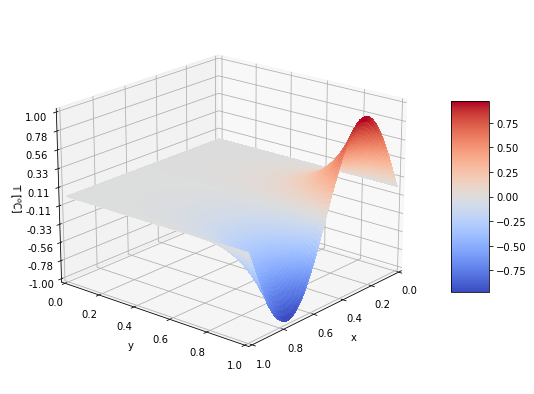

In [4]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


fig = plt.figure(figsize=(12,7))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Us, rstride=1, cstride=1, cmap=cm.coolwarm,edgecolor = 'none',
                       linewidth=0, antialiased=False)
ax.set_zlim(0, 110)
#, rstride=1, cstride=1, cmap=cm.coolwarm,
                       #linewidth=0, antialiased=False
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('T [$^o$C]')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(-1,1)
ax.view_init(20,40)

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [5]:
#analytical solution found in 3a
def u(x,y):
    return (1/np.sinh(2*np.pi))*np.sin(2*np.pi*x)*np.sinh(2*np.pi*y)

In [12]:
#constructing L2 error plots
#starting with the x discretization. for this, we should keep y a high number so that the error comes mainly from x

#max amount of y-steps:
My = 1750
#max amount of x-steps: 2**10
imax = 10

#constructing an array to hold all the different errors
errlst_x = np.zeros(imax)

#making a for look to iterate through the different stepsizes
for i in trange(1,imax+1):
    #made a function to calculate the U-matrix for any h, k
    Us, xs, ys = five_point_laplace(2**i,My)
    #creating X and Y meshes
    X,Y = np.meshgrid(xs,ys)
    
    #calculating the relative error through finding the 2-norm of the difference between u and U, and dividing this by u
    #thereby for any h,k we would use the whole matrix to find the error
    errlst_x[i-1] = np.sqrt(np.sum(((u(X,Y)-Us)**2))/np.sum((u(X,Y)**2)))


100%|██████████| 10/10 [02:28<00:00, 14.88s/it]


[1.39706771e-01 4.77092647e-02 1.44310534e-02 4.01899777e-03
 1.06488512e-03 2.74621066e-04 6.99968474e-05 1.79177365e-05
 4.77989617e-06 1.48050492e-06]


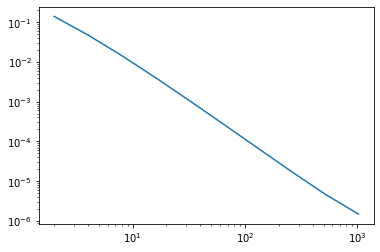

In [13]:
#x discretization
i_lst = np.linspace(1,imax,imax)
plt.loglog(2**i_lst,errlst_x)

print(errlst_x)

100%|██████████| 10/10 [02:11<00:00, 13.19s/it]


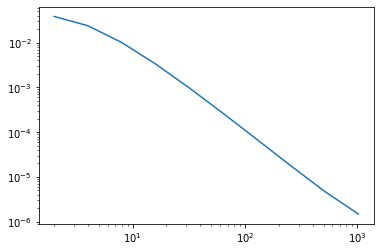

In [14]:
#y discretization
Mx = 1750

errlst_y = np.zeros(imax)

for i in trange(1,imax+1):
    Us, xs, ys = five_point_laplace(Mx,2**i)

    X,Y = np.meshgrid(xs,ys)
    
    errlst_y[i-1] = np.sqrt(np.sum(((u(X,Y)-Us)**2))/np.sum((u(X,Y)**2)))

plt.loglog(2**i_lst,errlst_y)

100%|██████████| 10/10 [00:32<00:00,  3.28s/it]


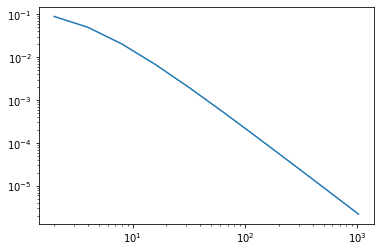

In [15]:
#eventuelt: diskretisering av begge to

#y discretization

errlst_xy = np.zeros(imax)

for i in trange(1,imax+1):
    Us, xs, ys = five_point_laplace(2**i,2**i)

    X,Y = np.meshgrid(xs,ys)
    
    errlst_xy[i-1] = np.sqrt(np.sum(((u(X,Y)-Us)**2))/np.sum((u(X,Y)**2)))

plt.loglog(2**i_lst,errlst_xy)

In [11]:
m=np.linspace(1,10,10)

file = open('error_x', 'w')

x = 2**m

y = errlst_x

z = np.array([x,y])

for i in zip(*z):
    file.write("{0}\t{1}\n".format(*i))

file.close()


file = open('error_y', 'w')

x = 2**m

y = errlst_y

z = np.array([x,y])

for i in zip(*z):
    file.write("{0}\t{1}\n".format(*i))

file.close()


file = open('error_xy', 'w')

x = 2**m

y = errlst_xy

z = np.array([x,y])

for i in zip(*z):
    file.write("{0}\t{1}\n".format(*i))

file.close()